#<font color = '33E8FF' size = '5'><b>Problem Statement</b></font>

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

**Business Objective**

The aim is to build a build a multiclass classification model using a custom convolutional neural network in TensorFlow.

# <font color='33E8FF' size='5'><b>Reading and Understanding Data</b></font>

We will import the dataset and understand the data

### Importing all the important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
# suppress the warnings
import warnings
warnings.filterwarnings("ignore")

### Reading the data

In [15]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [16]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root = '/content/gdrive/MyDrive/Melanoma_Case_Study'
data_dir_train = pathlib.Path(root + "/Train")
data_dir_test = pathlib.Path(root + '/Test')

In [19]:
# Lets count the size of the data sets for Train and Test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Count of Training images: {}'.format(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Count of Test images: {}'.format(image_count_test))

Count of Training images: 2239
Count of Test images: 118


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset
Define some parameters for the loader:

In [20]:
# batch size, image height and width
batch_size = 32
img_height = 180
img_width = 180

We will use 80% of the images for training, and rest 20% for validation

In [21]:
## Loading the training data
## we will use seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed = 123,
                                                               validation_split = 0.2,
                                                               image_size = (img_height,img_width),
                                                               batch_size = batch_size,
                                                               subset='training')
     

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [22]:
## Loading the validation data
## we will use seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed = 123,
                                                               validation_split = 0.2,
                                                               image_size = (img_height,img_width),
                                                               batch_size = batch_size,
                                                               subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [23]:
## Loading the test data
## we will use seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                              seed=123,
                                                              image_size = (img_height,img_width),
                                                              batch_size = batch_size)

Found 118 files belonging to 9 classes.


In [24]:
# Listing all the classes of skin cancer and storing them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#<font color='33E8FF' size='5'><b>Data **Visualization**</b></font>

* We will code to visualize one instance of all the nine classes present in the dataset

In [28]:
# method to visualize one instance of all the 9 classes
def plot_9_instance():
  plt.figure(figsize=(15,15))
  for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    img = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(img)

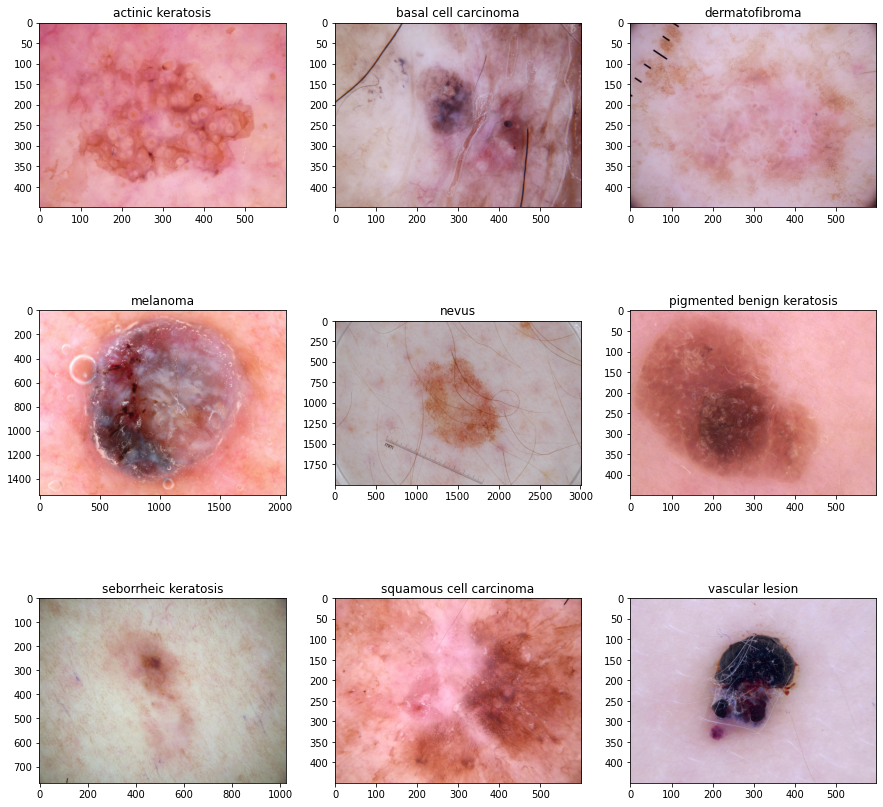

In [29]:
# display one instance image of all the 9 classes
plot_9_instance()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [33]:
# configure the data sets for the performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#<font color='33E8FF' size='5'><b>Building the model</b></font>

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).

In [34]:
preprocessing_layers = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255 , input_shape=(180,180,3))

In [35]:
# Building the model
input_shape = (180,180,3)
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(preprocessing_layers)

# Convolution layer with 2 - 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Flaaten 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

In [36]:
## Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 180, 180, 32)      0         
                                                        

### Compile the model
An appropirate optimiser and loss function for model training

In [46]:
### compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [47]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 180, 180, 32)      0         
                                                        

### Train the model

In [48]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 735s 3s/step - loss: 15.2127 - accuracy: 0.3025 - val_loss: 25.2969 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0339 - accuracy: 0.3186 - val_loss: 34.2429 - val_accuracy: 0.1790
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.8667 - accuracy: 0.3683 - val_loss: 30.9375 - val_accuracy: 0.1790
Epoch 4/20
56/56 [==============================] - 5s 94ms/step - loss: 1.7459 - accuracy: 0.3901 - val_loss: 24.9698 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 5s 95ms/step - loss: 1.6771 - accuracy: 0.4007 - val_loss: 18.3406 - val_accuracy: 0.1745
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 1.6557 - accuracy: 0.4241 - val_loss: 14.0895 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 1.5869 - accuracy: 0.4464 - val_loss: 8.3916 - val_accuracy: 0.2640
Epoch 

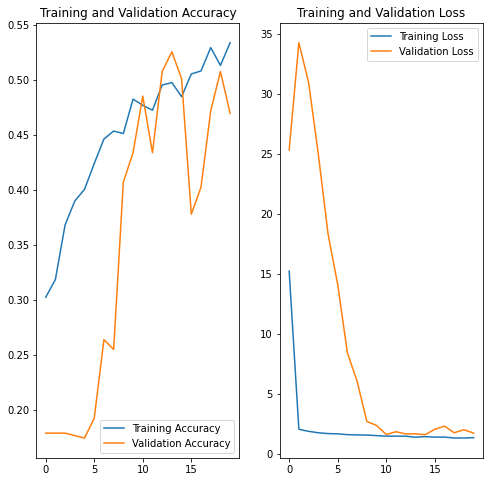

In [49]:
# visualizing the results
def plot_visuals_result(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# call the functions  
plot_visuals_result(history,epochs)

In [50]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
val_loss, accu_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accu_val)
print("Loss: ",loss)
print("Validation Loss", val_loss)

14/14 [==============================] - 0s 22ms/step - loss: 1.7174 - accuracy: 0.4698
Accuracy:  0.5251116156578064
Validation Accuracy:  0.46979865431785583
Loss:  1.3512744903564453
Validation Loss 1.7174075841903687


<font color='Green' size='3'><b>Inference :</b></font> 

1.   Training accuracy increases linearly , where as the validation accuracy increases and decreases
2.   Training loss dereases with epochs whereas validation loss increases the decreases
3.   Training accuracy is 52% whereas the Validation accuracy is 46.9% and the diffrence notifies there is an overfitting in the model

#<font color='33E8FF' size='5'><b>Data augmentation strategy to resolve underfitting/overfitting</b></font>
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformation

In [64]:
# data augmentation 
# importing the libraray for ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
# calling the datagenerator function
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
# image classification classes
image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']
# training set
train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 32
 )
# validation set
valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 32
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


### Create the model, compile and train the model

In [65]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()


# Convolution layer with 2 - 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


# Flaaten 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

# summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 activation_21 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                      

In [68]:
# compiling the model
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [69]:
# Training the model
epochs = 20
history = model.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs
)

Epoch 1/20
28/28 [==============================] - 34s 1s/step - loss: 6.0827 - accuracy: 0.4989 - val_loss: 1.5472 - val_accuracy: 0.3125
Epoch 2/20
28/28 [==============================] - 31s 1s/step - loss: 0.8142 - accuracy: 0.6270 - val_loss: 1.5120 - val_accuracy: 0.3333
Epoch 3/20
28/28 [==============================] - 31s 1s/step - loss: 0.7394 - accuracy: 0.6674 - val_loss: 1.4910 - val_accuracy: 0.4375
Epoch 4/20
28/28 [==============================] - 34s 1s/step - loss: 0.6828 - accuracy: 0.6966 - val_loss: 1.4883 - val_accuracy: 0.5417
Epoch 5/20
28/28 [==============================] - 35s 1s/step - loss: 0.6731 - accuracy: 0.6764 - val_loss: 1.1945 - val_accuracy: 0.5625
Epoch 6/20
28/28 [==============================] - 31s 1s/step - loss: 0.6501 - accuracy: 0.7000 - val_loss: 1.0790 - val_accuracy: 0.5417
Epoch 7/20
28/28 [==============================] - 30s 1s/step - loss: 0.6491 - accuracy: 0.6978 - val_loss: 1.4020 - val_accuracy: 0.4375
Epoch 8/20
28/28 [==

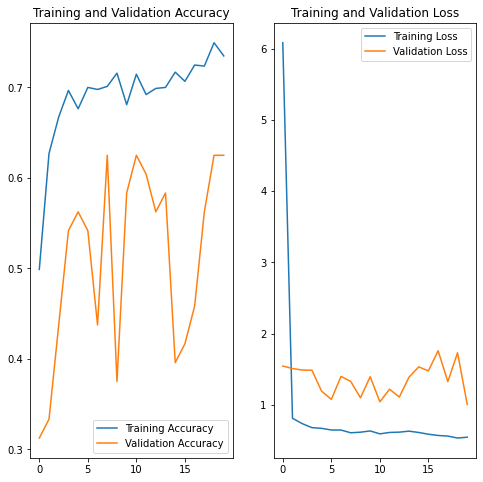

In [70]:
# call the functions to visualize the results
plot_visuals_result(history,epochs)

In [71]:
# Accuracy and Validation accuracy of the model
loss, accuracy = model.evaluate(train_batches, verbose=1,)
val_loss, accu_val = model.evaluate(valid_batches, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accu_val)
print("Loss: ",loss)
print("Validation Loss", val_loss)

2/2 [==============================] - 4s 829ms/step - loss: 1.0008 - accuracy: 0.5625
Accuracy:  0.6258426904678345
Validation Accuracy:  0.5625
Loss:  0.778816282749176
Validation Loss 1.000752329826355


<font color='Green' size='3'><b>Inference :</b></font> 

1.   Training accuracy increases linearly , where as the validation accuracy increases and decreases
2.   Training loss dereases with epochs whereas validation also decreases
3.   Training accuracy is 62.54% whereas the Validation accuracy is 56.25% and the diffrence notifies there is an **overfitting in the model**
4.   There is an improment in the Training and Validation accouracy of the model from the previous model

### Class distribution:

Class imbalance can have a detrimental effect on the final model quality. Hence it is important to check how is the distribution of classes in the data

In [72]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


<font color='Green' size='3'><b>Inference :</b></font> 

1.   seborrheic keratosis have least samples - 77 samples
2.   pigmented benign keratosis have high samples - 462 samples

#<font color='33E8FF' size='5'><b> Handling class imbalances:</b></font>
Rectifing class imbalances present in the training dataset with Augmentor library.

In [73]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
path_to_training_dataset="/content/gdrive/MyDrive/Melanoma_Case_Study/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4B6E105BB0>: 100%|██████████| 500/500 [00:22<00:00, 21.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4B6E1890D0>: 100%|██████████| 500/500 [00:19<00:00, 25.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4B6E0C8FA0>: 100%|██████████| 500/500 [00:19<00:00, 25.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F4C005A0790>: 100%|██████████| 500/500 [01:44<00:00,  4.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F4B9420A9A0>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4B96A54EB0>: 100%|██████████| 500/500 [00:17<00:00, 28.36 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F4BAC58A670>: 100%|██████████| 500/500 [00:41<00:00, 12.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4B96A0D490>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_Case_Study/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4B6E139190>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [75]:
# Lets count of the data sets for Train set
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print('Count of Training images: {}'.format(image_count_train))

Count of Training images: 4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [77]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0010863.jpg_162b0323-070e-4f68-95dc-fd5dc9238548.jpg',
 '/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0010648.jpg_de8f6fdc-776a-420b-a5ee-5345c9615541.jpg',
 '/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_9df0af75-9cc6-4e77-84f3-f524942a0db1.jpg',
 '/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0009960.jpg_3bfab257-f227-4700-b9b1-d56927a94137.jpg',
 '/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0000162.jpg_850ab38f-dcd8-4458-a44b-4a3a4a3cc15a.jpg',
 '/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0010401.jpg_9912dd28-8138-4b30-9376-d36eec2a5249.jpg',
 '/content/gdrive/MyDrive/Melanoma_Case_Study/Train/melanoma/output/melanoma_original_ISIC_0009916.jpg_a59df3f3-5a9e-4dd0-a5

In [78]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [80]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [82]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [83]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [84]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed = 123,
                                                               validation_split = 0.2,
                                                               image_size = (img_height,img_width),
                                                               batch_size = batch_size,
                                                               subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [85]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                          data_dir_train,
                                                          seed=123,
                                                          validation_split = 0.2,
                                                          subset = 'validation',
                                                          image_size=(img_height, img_width),
                                                          batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [86]:
# Building the model
input_shape = (180,180,3)
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 2 - 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


# Flaaten 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

# summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_27 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 activation_28 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_10 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                      

### Compile your model (Choose optimizer and loss function appropriately)

In [89]:
# compiling the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

### Train your model


In [90]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 36s 206ms/step - loss: 6.0995 - accuracy: 0.2101 - val_loss: 15.5458 - val_accuracy: 0.0831
Epoch 2/30
169/169 [==============================] - 35s 199ms/step - loss: 2.0317 - accuracy: 0.2292 - val_loss: 19.2428 - val_accuracy: 0.0817
Epoch 3/30
169/169 [==============================] - 35s 199ms/step - loss: 1.9716 - accuracy: 0.2430 - val_loss: 17.1892 - val_accuracy: 0.1782
Epoch 4/30
169/169 [==============================] - 37s 210ms/step - loss: 1.9331 - accuracy: 0.2574 - val_loss: 32.5141 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 34s 198ms/step - loss: 1.9672 - accuracy: 0.2361 - val_loss: 2.6452 - val_accuracy: 0.1856
Epoch 6/30
169/169 [==============================] - 35s 198ms/step - loss: 1.9202 - accuracy: 0.2502 - val_loss: 4.1333 - val_accuracy: 0.2027
Epoch 7/30
169/169 [==============================] - 35s 199ms/step - loss: 1.8371 - accuracy: 0.2904 - val_loss: 2.2281 - va

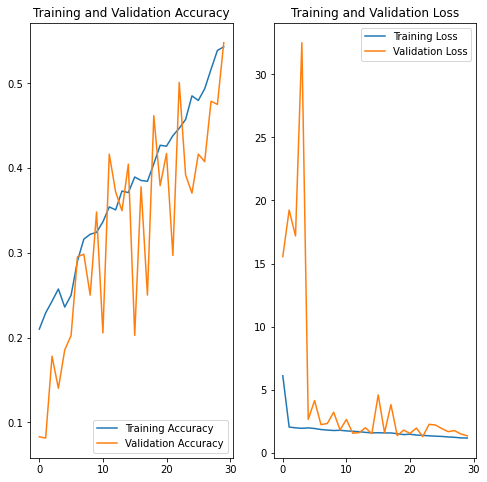

In [91]:
# call the functions to visualize the results
plot_visuals_result(history,epochs)

In [92]:
# Accuracy and Validation accuracy of the model
loss, accuracy = model.evaluate(train_ds, verbose=1,)
val_loss, accu_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accu_val)
print("Loss: ",loss)
print("Validation Loss", val_loss)

43/43 [==============================] - 6s 116ms/step - loss: 1.3409 - accuracy: 0.5479
Accuracy:  0.5829005837440491
Validation Accuracy:  0.5478841662406921
Loss:  1.1283022165298462
Validation Loss 1.3409284353256226


<font color='Green' size='3'><b>Inference :</b></font> 

1.   Training accuracy increases linearly , where as the validation accuracy increases a
2.   Training loss dereases with epochs whereas validation also decreases
3.   Training accuracy is 58% whereas the Validation accuracy is aroung 55% and the diffrence notifies there is very less diffrence in accuracy between the training and validation accuracy